**End to end model development of obesity level predictive model**

In [438]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score,roc_curve

In [439]:
g = pd.read_csv('obesity_level.csv')

In [440]:
g.sample(5)

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,obesity_level
167,20.0,Male,1.650000,80.000000,no,no,2.0,3.0,no,no,2.00000,yes,1.0,2.00000,Sometimes,Walking,Overweight_Level_II
426,22.0,Male,1.750000,70.000000,no,no,2.0,3.0,no,no,3.00000,no,1.0,1.00000,Sometimes,Public_Transportation,Normal_Weight
371,17.0,Male,1.620000,69.000000,Sometimes,yes,3.0,1.0,yes,no,2.00000,yes,1.0,2.00000,Always,Public_Transportation,Overweight_Level_I
441,18.0,Female,1.550000,50.000000,no,yes,3.0,3.0,no,no,1.00000,yes,1.0,2.00000,Frequently,Public_Transportation,Normal_Weight
1842,26.0,Female,1.641098,111.818345,Sometimes,yes,3.0,3.0,no,no,2.55057,yes,0.0,0.20482,Sometimes,Public_Transportation,Obesity_Type_III


"obesity_level" is the target variable

In [441]:
g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

In [442]:
g.shape

(2111, 17)

In [443]:
g.isnull().sum()

,0
Age,0
Gender,0
Height,0
Weight,0
CALC,0
FAVC,0
FCVC,0
NCP,0
SCC,0
SMOKE,0


Dependent and independent columns



In [444]:
X = g.iloc[:,:-1]        #independent columns/features
X.sample(5)

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS
218,21.000000,Female,1.500000,42.300000,no,no,1.000000,1.000000,no,no,2.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation
221,23.000000,Male,1.720000,82.000000,Sometimes,yes,2.000000,1.000000,no,no,1.000000,yes,1.000000,1.000000,Sometimes,Public_Transportation
665,21.274628,Female,1.737453,50.479039,no,yes,3.000000,3.489918,no,no,1.326694,yes,0.791929,0.128394,Frequently,Public_Transportation
721,17.823438,Female,1.708406,50.000000,Sometimes,yes,1.642241,3.452590,no,no,1.099231,no,0.418875,1.000000,Sometimes,Public_Transportation
1413,40.466313,Female,1.559005,77.601483,Sometimes,yes,2.000000,3.000000,no,no,1.572371,yes,0.000000,0.000000,Sometimes,Automobile


In [445]:
y = g.iloc[:,-1]
y.sample(5)

,obesity_level
1758,Obesity_Type_II
523,Insufficient_Weight
1547,Obesity_Type_II
1964,Obesity_Type_III
854,Overweight_Level_I


**splitting data into training and test data**

In [446]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [447]:
y_train.head()

,obesity_level
1630,Obesity_Type_II
7,Normal_Weight
1421,Obesity_Type_I
770,Overweight_Level_I
1742,Obesity_Type_II


In [448]:
len(X_train),len(y_train)

(1688, 1688)

In [449]:
len(X_test),len(y_test)

(423, 423)

**2.Feature engineering stage**



1.Handling missing values

In [450]:
X_train.shape

(1688, 16)

In [451]:
X_train.isnull().sum()

,0
Age,0
Gender,0
Height,0
Weight,0
CALC,0
FAVC,0
FCVC,0
NCP,0
SCC,0
SMOKE,0


In [452]:
X_test.isnull().sum()

,0
Age,0
Gender,0
Height,0
Weight,0
CALC,0
FAVC,0
FCVC,0
NCP,0
SCC,0
SMOKE,0


2.converting categorical data into numerical data

In [453]:
#seperating numerical and categorical columns
X_train_num = X_train.select_dtypes(exclude='object')
X_train_cat = X_train.select_dtypes(include='object')

In [454]:
X_train_num.sample(3)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
409,33.000000,1.550000,55.000000,3.000000,1.000000,3.000000,2.000000,1.000000
918,21.996118,1.730199,78.997062,2.277077,1.000000,2.000000,1.061743,0.000000
1393,23.096353,1.728183,97.959899,2.000000,2.986172,2.364208,2.492402,1.632506


In [455]:
X_train_cat.sample(3)

,Gender,CALC,FAVC,SCC,SMOKE,family_history_with_overweight,CAEC,MTRANS
1197,Male,no,yes,no,no,yes,Sometimes,Automobile
916,Female,Sometimes,yes,no,no,yes,Sometimes,Automobile
716,Male,no,yes,no,no,yes,Sometimes,Automobile


In [456]:
X_test_num=X_test.select_dtypes(exclude='object')
X_test_cat=X_test.select_dtypes(include='object')

We'll be having two types of categorical data here.

1.Nominal data : having equal priority[Gender,FAVC,SCC,SMOKE,family_history_with_overweight	]

2.ordinal data : [CALC,CAEC,	MTRANS]

In [457]:
X_train_cat.reset_index(drop=True,inplace=True)

In [458]:
#for nominal type
from sklearn.preprocessing import OneHotEncoder
O_hot = OneHotEncoder(handle_unknown='ignore')
O_hot.fit(X_train_cat[['Gender','FAVC','SCC','SMOKE','family_history_with_overweight']])

OneHotEncoder(handle_unknown='ignore')

In [459]:
f_one = O_hot.transform(X_train_cat[['Gender','FAVC','SCC','SMOKE','family_history_with_overweight']]).toarray()
print(f_one)
labels = O_hot.get_feature_names_out()
labels

[[0. 1. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]]


array(['Gender_Female', 'Gender_Male', 'FAVC_no', 'FAVC_yes', 'SCC_no',
       'SCC_yes', 'SMOKE_no', 'SMOKE_yes',
       'family_history_with_overweight_no',
       'family_history_with_overweight_yes'], dtype=object)

In [460]:
#creating seperate dataframe for nominal categorical data
nom = pd.DataFrame(data=f_one,columns=labels)
nom.sample(5)

,Gender_Female,Gender_Male,FAVC_no,FAVC_yes,SCC_no,SCC_yes,SMOKE_no,SMOKE_yes,family_history_with_overweight_no,family_history_with_overweight_yes
1573,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1234,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
77,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
651,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1173,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [461]:
X_train_cat=pd.concat([X_train_cat,nom],axis=1)

In [462]:
X_train_cat = X_train_cat.drop(['Gender','FAVC','SCC','SMOKE','family_history_with_overweight'],axis = 1)

In [463]:
X_train_cat.sample(5)

,CALC,CAEC,MTRANS,Gender_Female,Gender_Male,FAVC_no,FAVC_yes,SCC_no,SCC_yes,SMOKE_no,SMOKE_yes,family_history_with_overweight_no,family_history_with_overweight_yes
1535,Sometimes,Sometimes,Public_Transportation,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1644,no,Sometimes,Public_Transportation,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1436,Sometimes,Sometimes,Public_Transportation,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,Sometimes,Sometimes,Public_Transportation,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
580,Sometimes,Sometimes,Public_Transportation,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [464]:
#for ordinal type
from sklearn.preprocessing import OrdinalEncoder
Od_e = OrdinalEncoder()

In [465]:
Od_e.fit(X_train_cat[['CALC','CAEC', 'MTRANS']])

OrdinalEncoder()

In [466]:
Od_e.categories_

[array(['Always', 'Frequently', 'Sometimes', 'no'], dtype=object),
 array(['Always', 'Frequently', 'Sometimes', 'no'], dtype=object),
 array(['Automobile', 'Bike', 'Motorbike', 'Public_Transportation',
        'Walking'], dtype=object)]

In [467]:
Od_e.get_feature_names_out()

array(['CALC', 'CAEC', 'MTRANS'], dtype=object)

In [468]:
f_ord = Od_e.transform(X_train_cat[['CALC','CAEC', 'MTRANS']])


In [469]:
#creating dataframe for ordinal categoricak data
Ord = pd.DataFrame(data = f_ord,columns=Od_e.get_feature_names_out())

In [470]:
X_train_cat = X_train_cat.drop(['CALC','CAEC', 'MTRANS'],axis = 1)

In [471]:
X_train_cat = pd.concat([X_train_cat,Ord],axis = 1)

In [472]:
X_train_cat.sample(5)

,Gender_Female,Gender_Male,FAVC_no,FAVC_yes,SCC_no,SCC_yes,SMOKE_no,SMOKE_yes,family_history_with_overweight_no,family_history_with_overweight_yes,CALC,CAEC,MTRANS
134,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0
1493,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,3.0
284,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0
400,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,3.0
1671,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,3.0


In [473]:
#seperating numerical and categorical columns in test_data
X_test_num = X_test.select_dtypes(exclude='object')
X_test_cat = X_test.select_dtypes(include='object')

In [474]:
X_test_cat.reset_index(drop=True,inplace=True)

In [475]:
X_test_num.sample(3)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
82,23.000000,1.670000,85.5,2.000000,3.000000,2.00000,0.000000,1.0
352,17.000000,1.600000,53.0,1.000000,3.000000,1.00000,2.000000,2.0
1351,39.213399,1.586301,80.0,2.020502,1.237454,1.93142,1.967973,0.0


In [476]:
X_test_cat.sample(3)

,Gender,CALC,FAVC,SCC,SMOKE,family_history_with_overweight,CAEC,MTRANS
279,Male,Sometimes,yes,no,no,yes,Sometimes,Automobile
13,Female,no,yes,no,no,yes,Sometimes,Public_Transportation
336,Male,Frequently,yes,yes,yes,yes,no,Automobile


We'll be having two types of categorical data here.

1.Nominal data : having equal priority[Gender,FAVC,SCC,SMOKE,family_history_with_overweight	]

2.ordinal data : [CALC,CAEC	MTRANS,obesity_level]

In [477]:
#for nominal
O_hot_t = OneHotEncoder(handle_unknown='ignore')
O_hot_t.fit(X_test_cat[['Gender','FAVC','SCC','SMOKE','family_history_with_overweight']])

OneHotEncoder(handle_unknown='ignore')

In [478]:
f_one_t = O_hot_t.transform(X_test_cat[['Gender','FAVC','SCC','SMOKE','family_history_with_overweight']]).toarray()
print(f_one_t)
labels = O_hot_t.get_feature_names_out()
labels

[[0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]]


array(['Gender_Female', 'Gender_Male', 'FAVC_no', 'FAVC_yes', 'SCC_no',
       'SCC_yes', 'SMOKE_no', 'SMOKE_yes',
       'family_history_with_overweight_no',
       'family_history_with_overweight_yes'], dtype=object)

In [479]:
#creating seperate dataframe for nominal categorical data
nom_t = pd.DataFrame(data=f_one_t,columns=labels)
nom_t.sample(5)

,Gender_Female,Gender_Male,FAVC_no,FAVC_yes,SCC_no,SCC_yes,SMOKE_no,SMOKE_yes,family_history_with_overweight_no,family_history_with_overweight_yes
332,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
347,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
340,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
283,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
52,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [480]:
X_test_cat=pd.concat([X_test_cat,nom_t],axis=1)

In [481]:
X_test_cat = X_test_cat.drop(['Gender','FAVC','SCC','SMOKE','family_history_with_overweight'],axis = 1)

In [482]:
X_test_cat.sample(5)

,CALC,CAEC,MTRANS,Gender_Female,Gender_Male,FAVC_no,FAVC_yes,SCC_no,SCC_yes,SMOKE_no,SMOKE_yes,family_history_with_overweight_no,family_history_with_overweight_yes
274,no,Sometimes,Automobile,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
337,Sometimes,Sometimes,Automobile,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
415,Sometimes,Sometimes,Public_Transportation,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
356,Sometimes,Sometimes,Public_Transportation,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
100,Sometimes,Sometimes,Public_Transportation,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [483]:
#for ordinal type
Od_e_t = OrdinalEncoder()

In [484]:
Od_e_t.fit(X_test_cat[['CALC','CAEC', 'MTRANS']])

OrdinalEncoder()

In [485]:
Od_e_t.categories_

[array(['Frequently', 'Sometimes', 'no'], dtype=object),
 array(['Always', 'Frequently', 'Sometimes', 'no'], dtype=object),
 array(['Automobile', 'Bike', 'Motorbike', 'Public_Transportation',
        'Walking'], dtype=object)]

In [486]:
Od_e_t.get_feature_names_out()

array(['CALC', 'CAEC', 'MTRANS'], dtype=object)

In [487]:
f_ord_t = Od_e_t.transform(X_test_cat[['CALC','CAEC', 'MTRANS']])


In [488]:
#creating dataframe for ordinal categoricak data
Ord_t = pd.DataFrame(data = f_ord_t,columns=Od_e_t.get_feature_names_out())

In [489]:
X_test_cat = X_test_cat.drop(['CALC','CAEC', 'MTRANS'],axis = 1)

In [490]:
X_test_cat = pd.concat([X_test_cat,Ord_t],axis = 1)

In [491]:
X_test_cat.sample(5)

,Gender_Female,Gender_Male,FAVC_no,FAVC_yes,SCC_no,SCC_yes,SMOKE_no,SMOKE_yes,family_history_with_overweight_no,family_history_with_overweight_yes,CALC,CAEC,MTRANS
84,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,3.0
394,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0
206,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0
185,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0
76,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,3.0


3.Handle outliers

--->If any data following normal distribution,then the data has less outliers

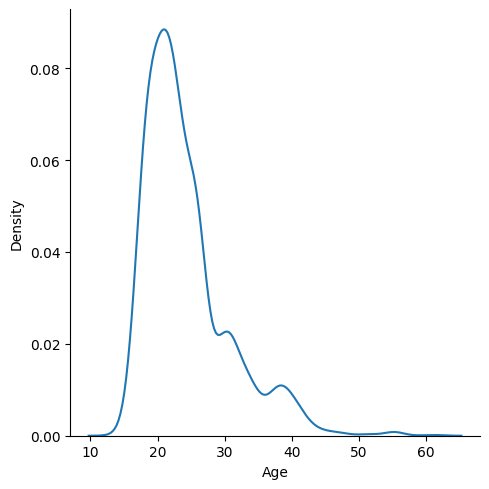

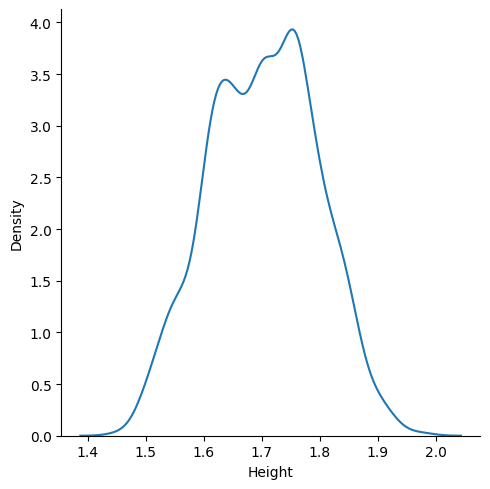

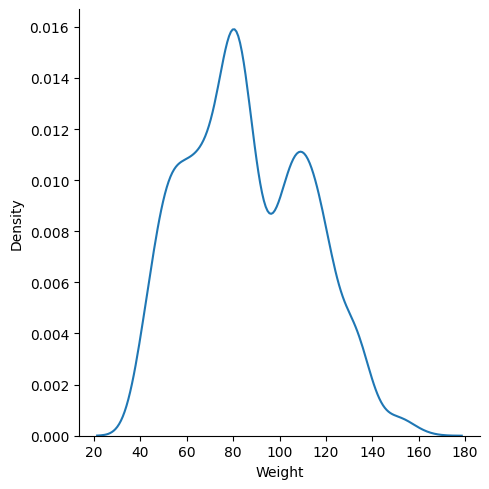

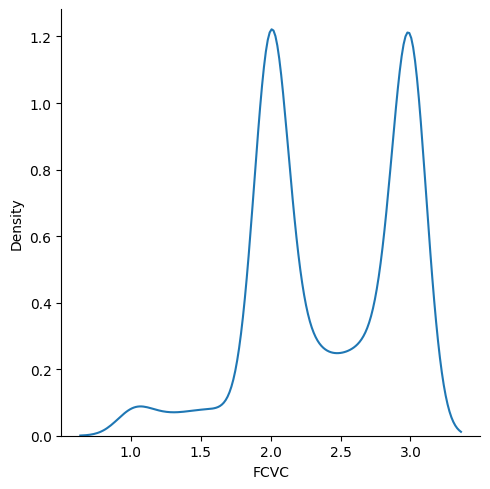

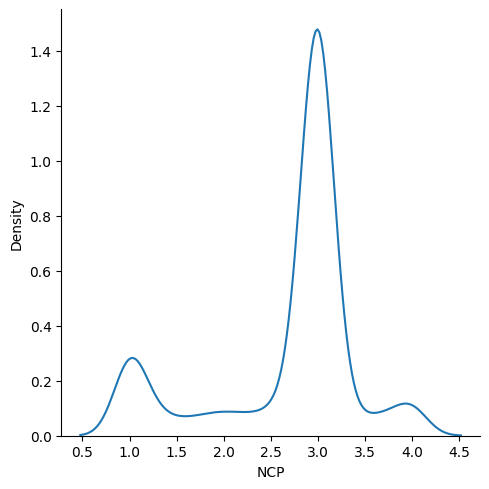

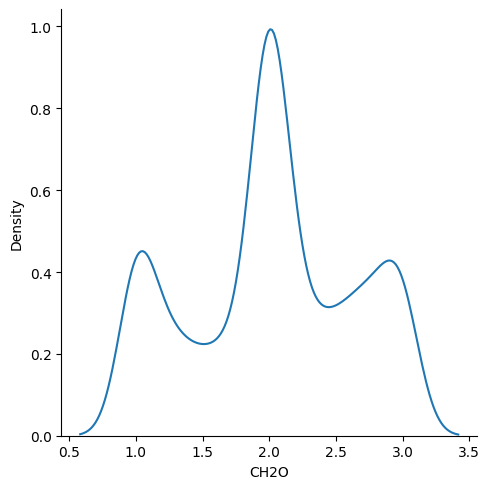

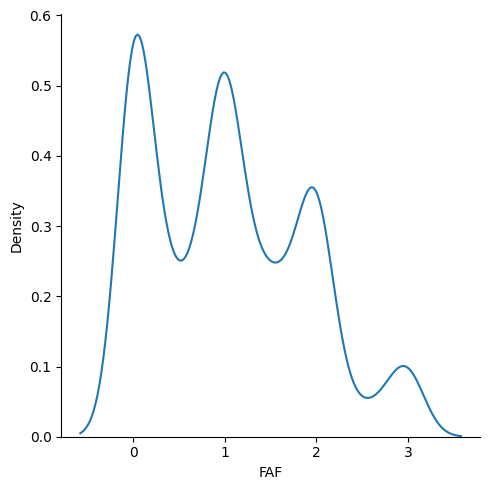

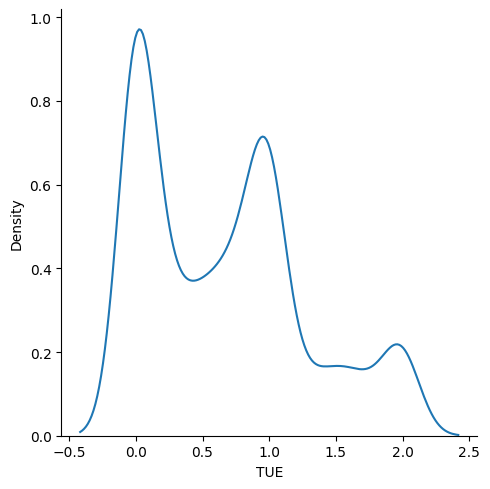

In [492]:
for i in X_train_num.columns:
  sns.displot(X_train_num[i],kind='kde')
  plt.show()

In [493]:
#for probplot
def plotting(data,var):
  plt.figure(figsize=(8,5))
  plt.subplot(1,3,1)
  plt.title(var)
  data[var].plot(kind='kde')

  plt.subplot(1,3,2)
  sns.boxplot(data[var])

  plt.subplot(1,3,3)
  stats.probplot(data[var],dist='norm',plot=plt)
  plt.show()

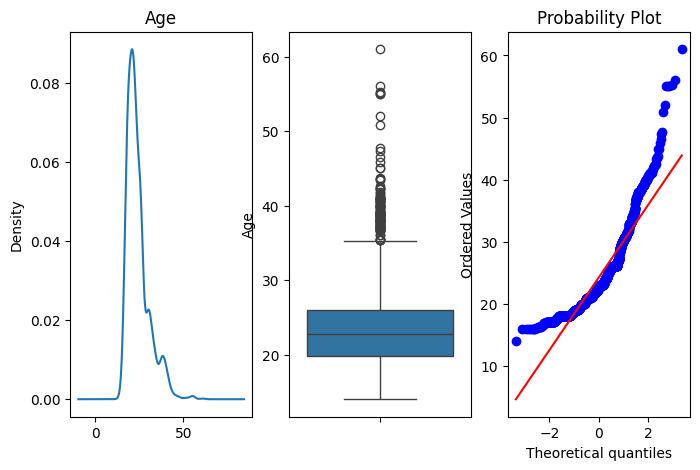

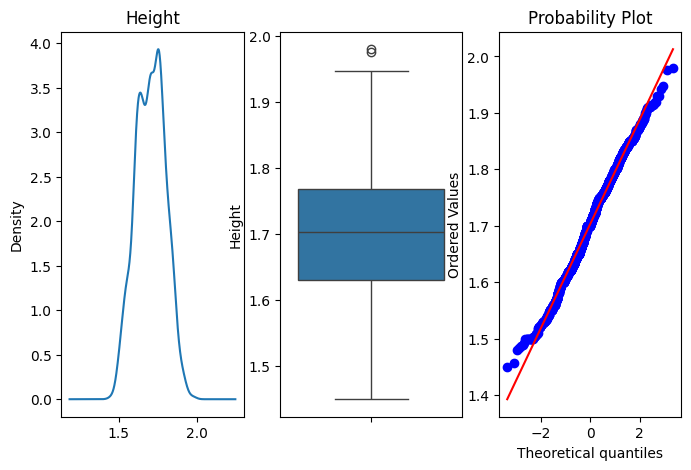

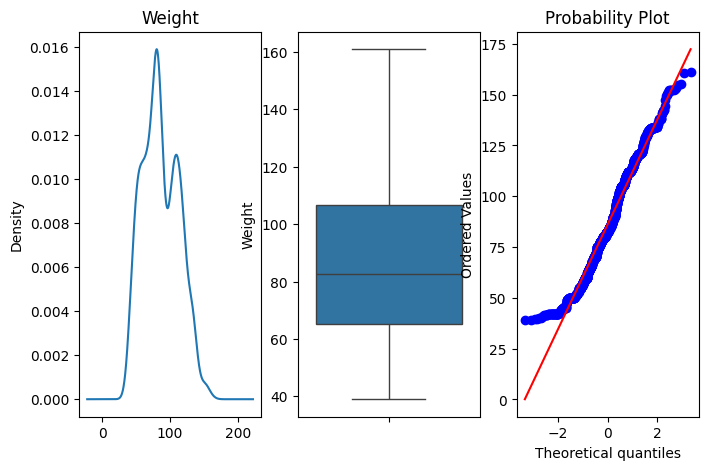

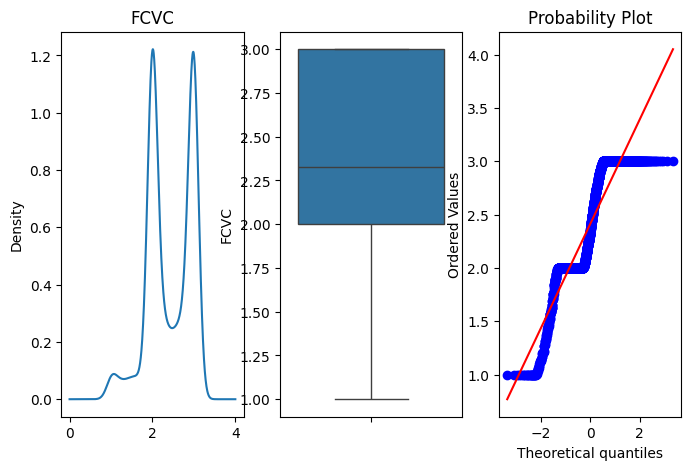

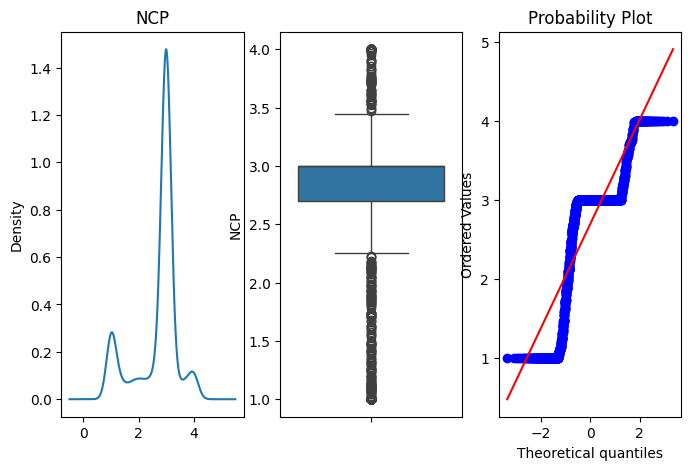

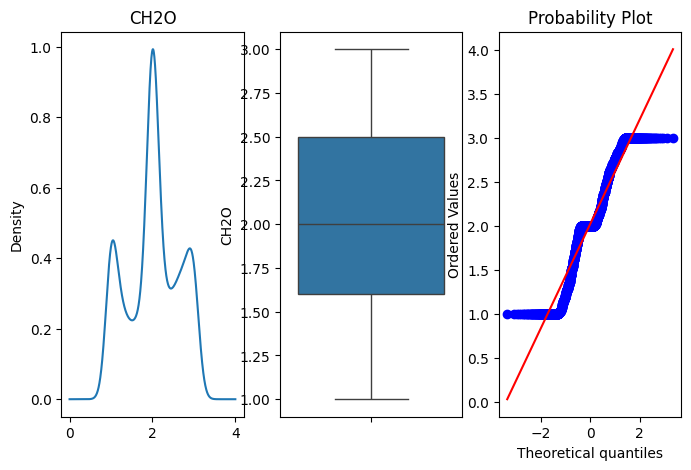

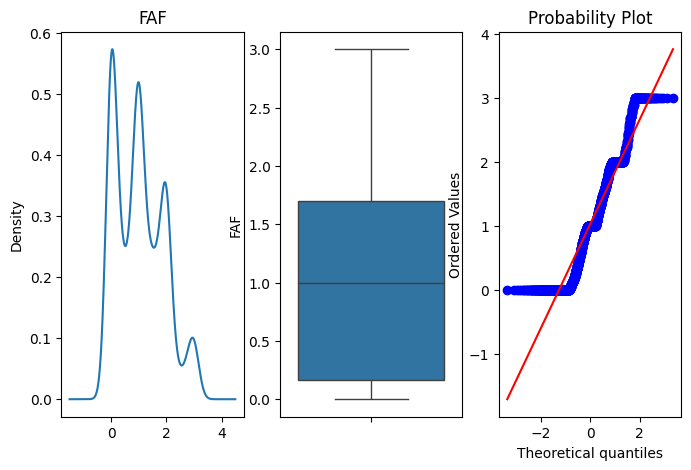

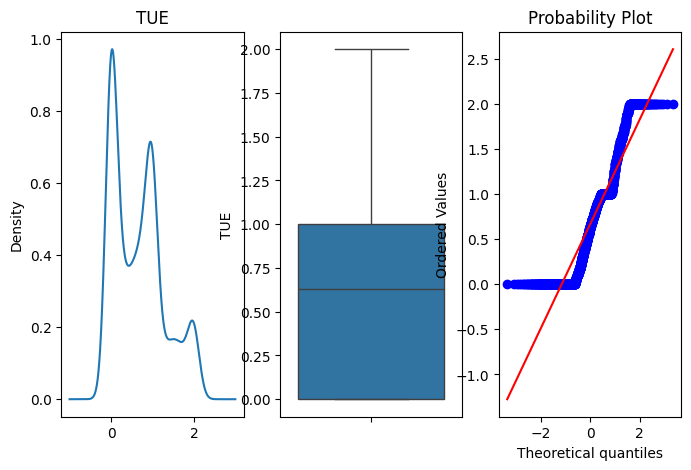

In [494]:
for i in X_train_num.columns:
  plotting(X_train_num,i)

In [495]:
X_train_num.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
1630,30.403205,1.696365,102.815983,2.791660,2.132290,1.254589,0.652736,1.040713
7,22.000000,1.640000,53.000000,2.000000,3.000000,2.000000,3.000000,0.000000
1421,21.587743,1.664752,94.256547,2.000000,2.976098,2.000000,0.000000,1.393220
770,21.029633,1.607082,67.722222,2.000000,3.691226,3.000000,1.228136,0.335200
1742,27.931432,1.805445,119.484614,2.911312,3.000000,2.501808,0.946760,0.785701


3.variable transformation : To make the data more suitable for modeling


In [496]:
# yeojohnson technique
for i in X_train_num.columns:
  X_train_num[i+'_yeo'],lam=stats.yeojohnson(X_train_num[i].fillna(X_train_num[i].mean()))



In [497]:
X_train_num.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Age_yeo', 'Height_yeo', 'Weight_yeo', 'FCVC_yeo', 'NCP_yeo',
       'CH2O_yeo', 'FAF_yeo', 'TUE_yeo'],
      dtype='object')

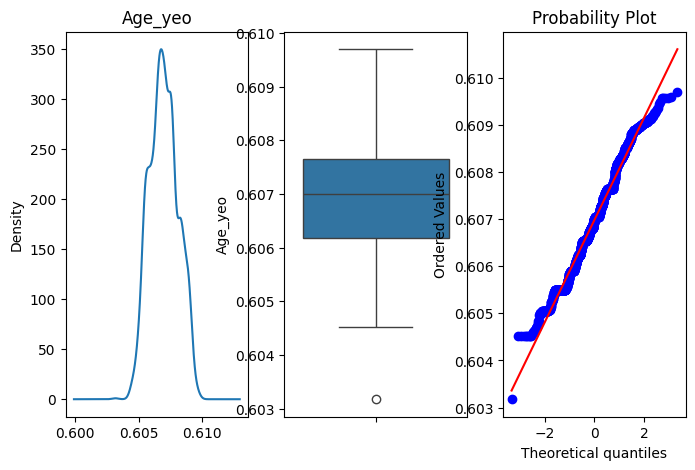

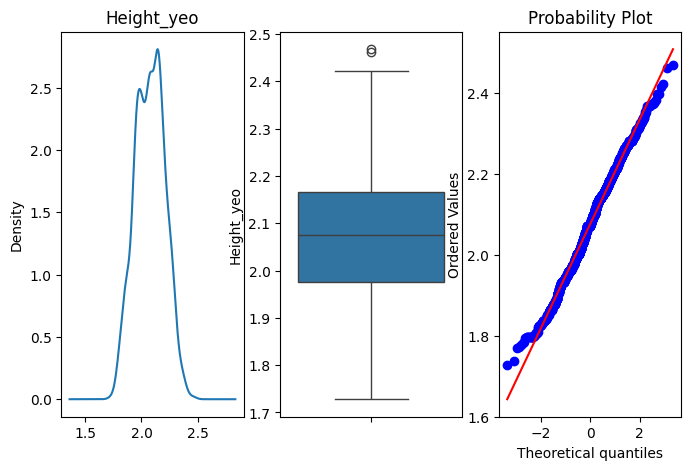

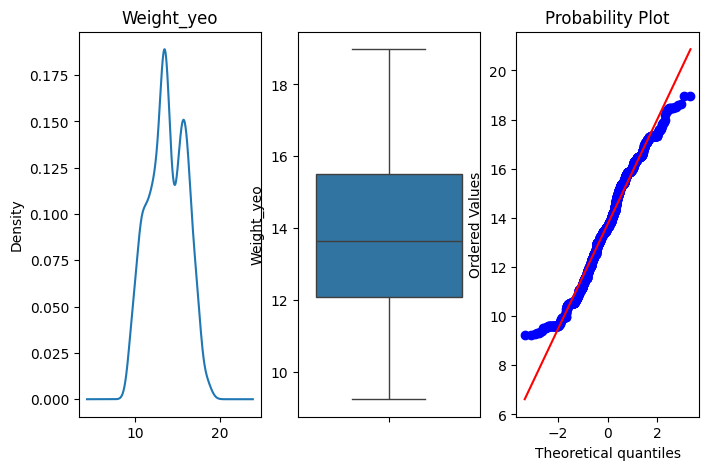

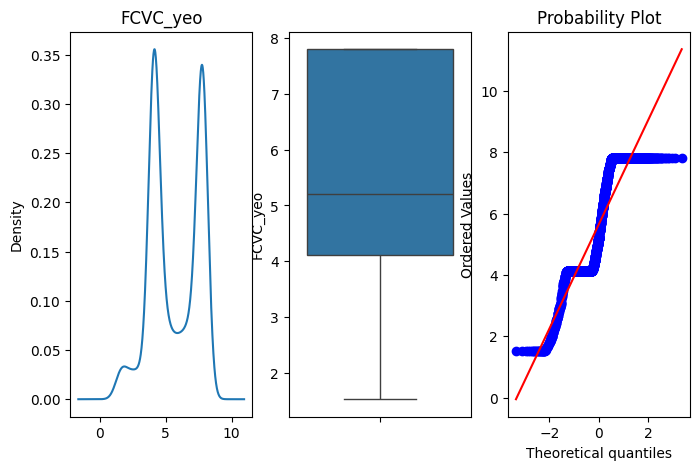

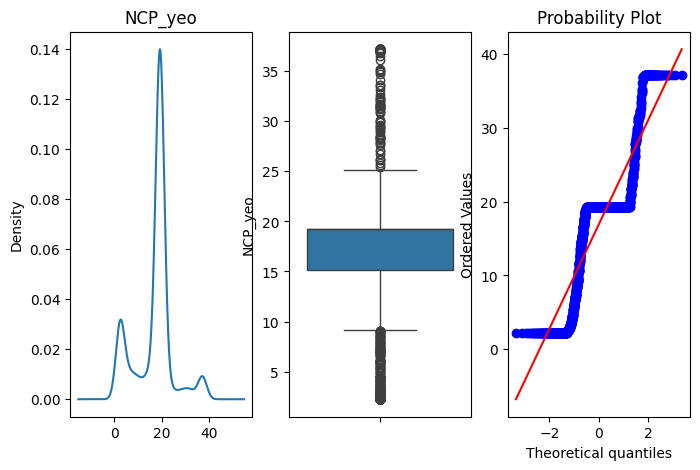

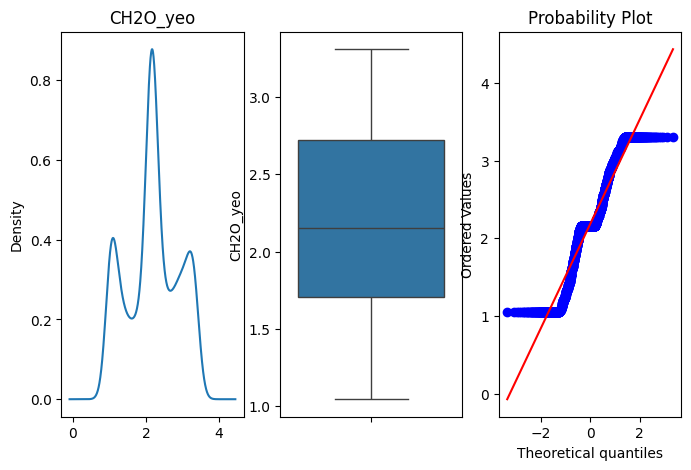

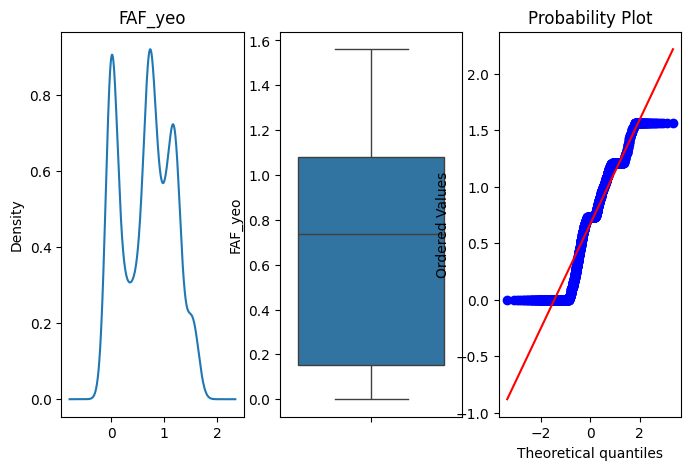

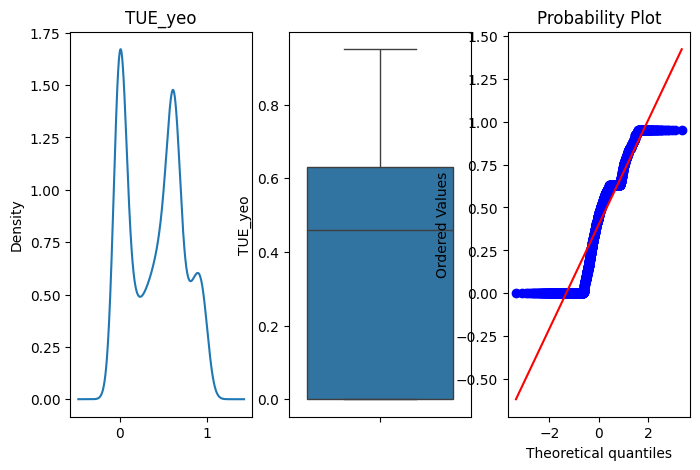

In [498]:
for i in X_train_num.columns:
  if '_yeo' in i:
    plotting(X_train_num,i)

In [499]:
for i in X_train_num.columns:
  if '_yeo' not in i:
    X_train_num=X_train_num.drop([i],axis=1)

In [500]:
X_train_num.columns

Index(['Age_yeo', 'Height_yeo', 'Weight_yeo', 'FCVC_yeo', 'NCP_yeo',
       'CH2O_yeo', 'FAF_yeo', 'TUE_yeo'],
      dtype='object')

Among all techniques,yeojohnson technique worked well.

In [501]:
#Applying yeojohnson technique on test data
for i in X_test_num.columns:
  X_test_num[i+'_yeo'],lam=stats.yeojohnson(X_test_num[i].fillna(X_test_num.mean()))

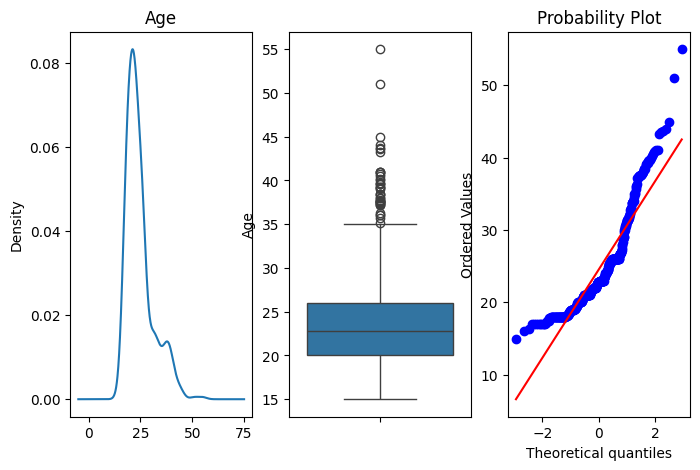

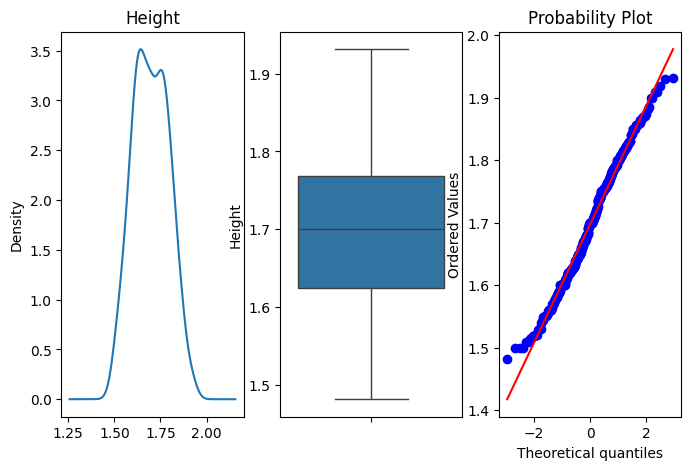

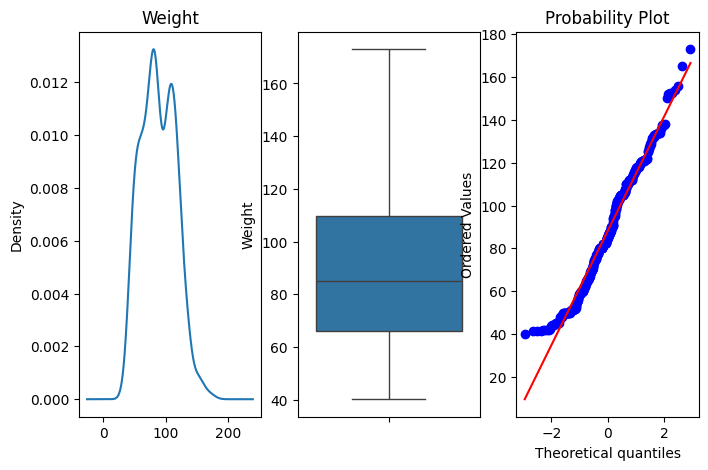

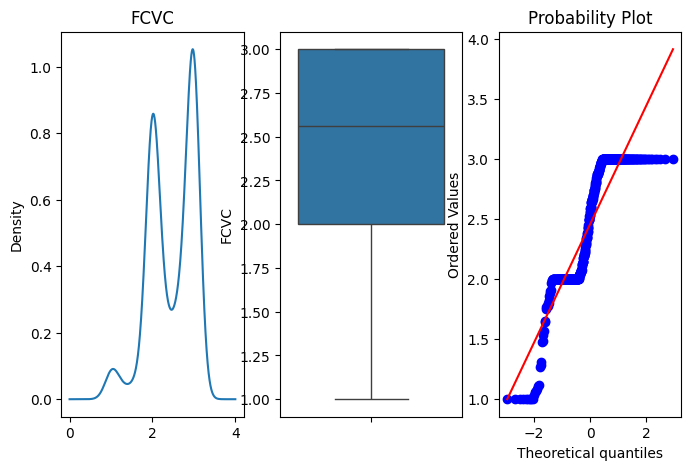

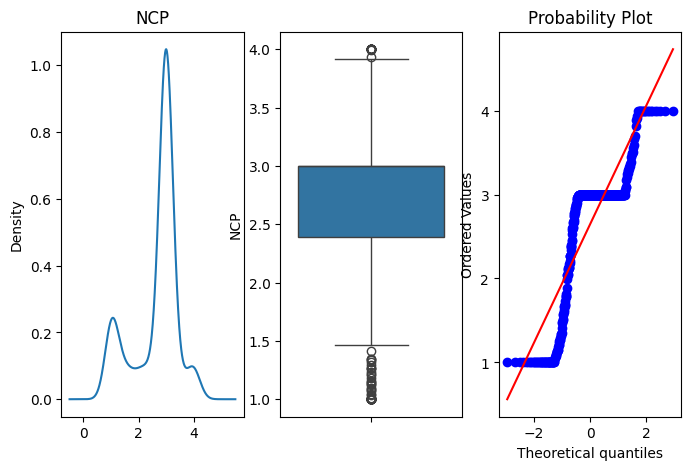

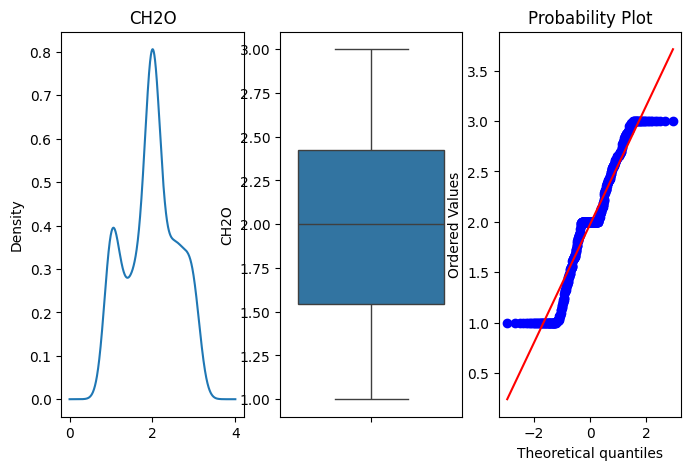

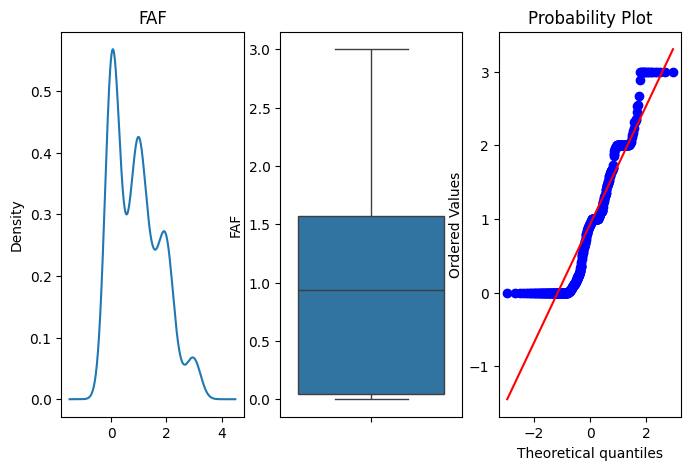

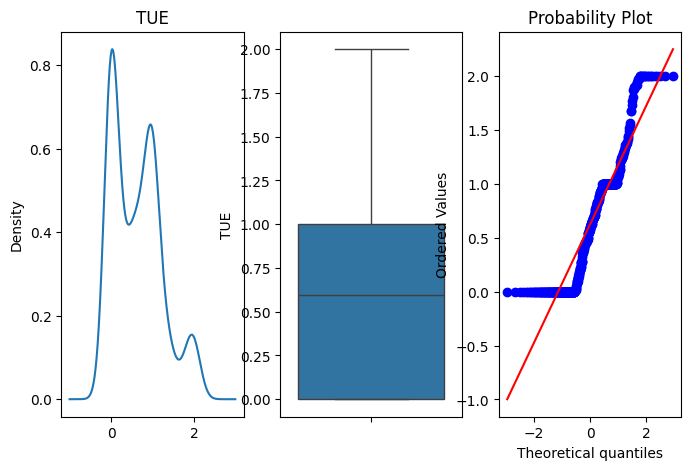

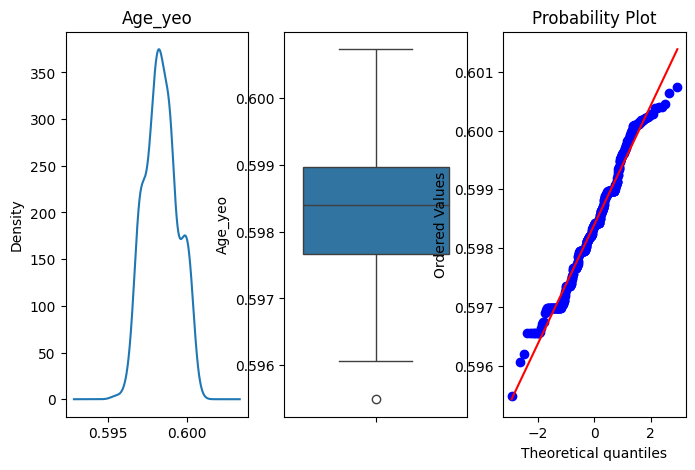

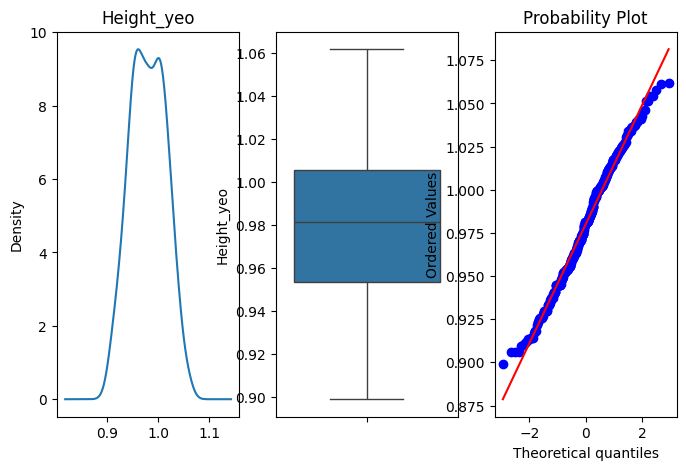

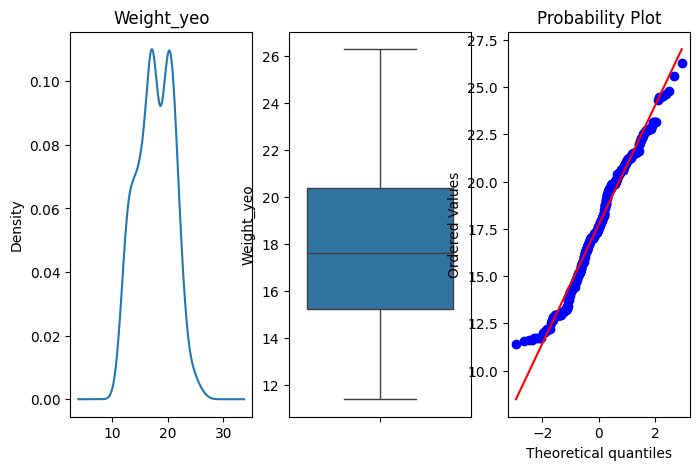

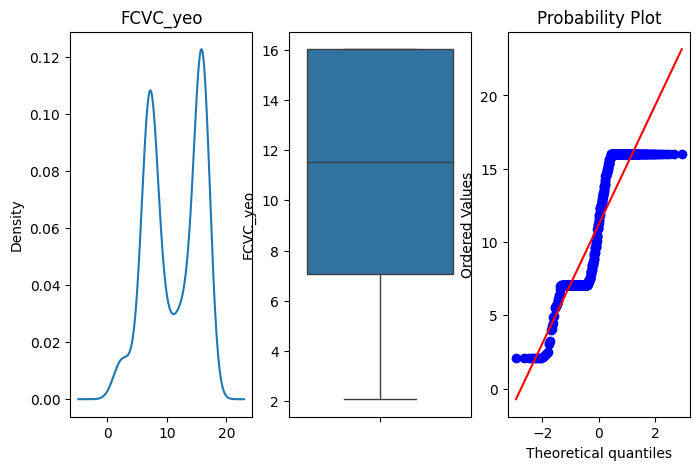

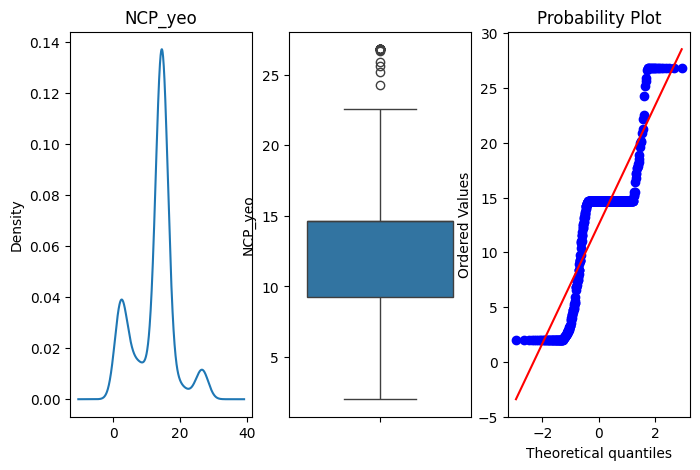

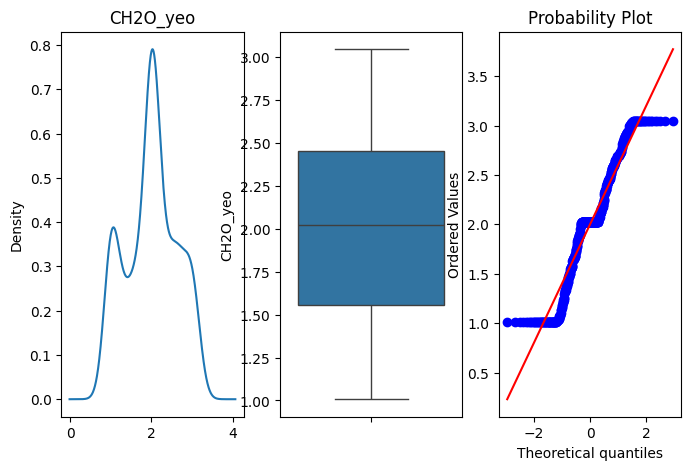

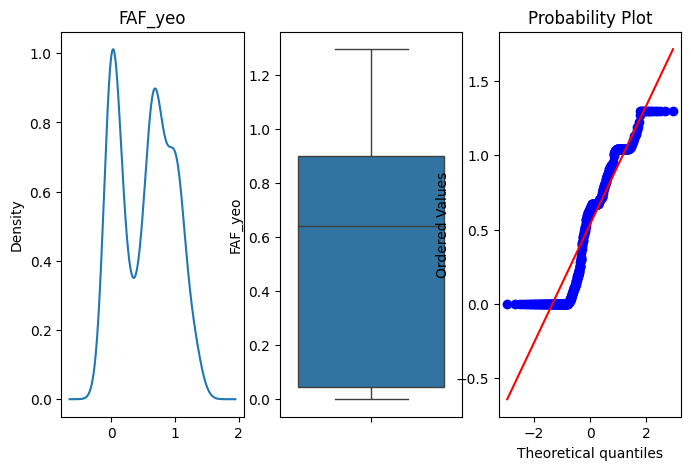

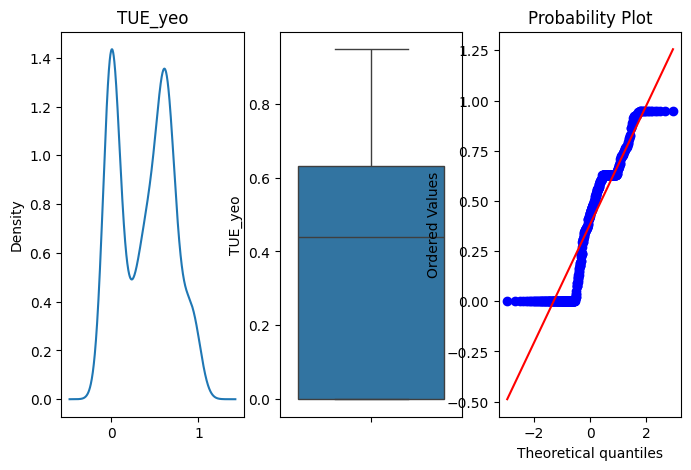

In [502]:
for i in X_test_num.columns:
  plotting(X_test_num,i)

In [503]:
for i in X_test_num.columns:
  if '_yeo' not in i:
    X_test_num=X_test_num.drop([i],axis=1)
X_test_num.columns

Index(['Age_yeo', 'Height_yeo', 'Weight_yeo', 'FCVC_yeo', 'NCP_yeo',
       'CH2O_yeo', 'FAF_yeo', 'TUE_yeo'],
      dtype='object')

4.Handling outliers

In [504]:
def find_out(data,var):
  plt.figure(figsize=(5,3))
  sns.boxplot(x=data[var])
  plt.show()

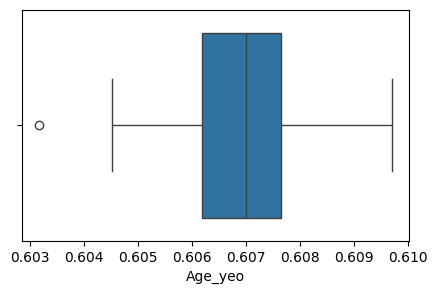

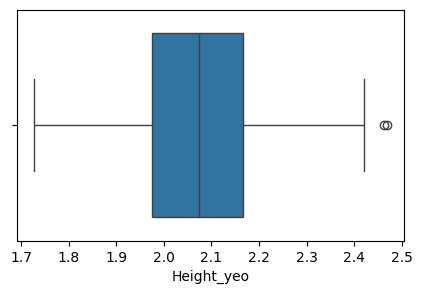

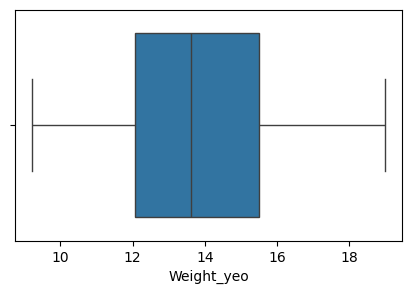

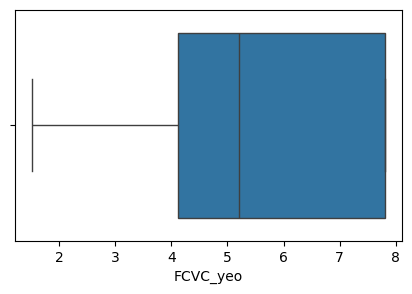

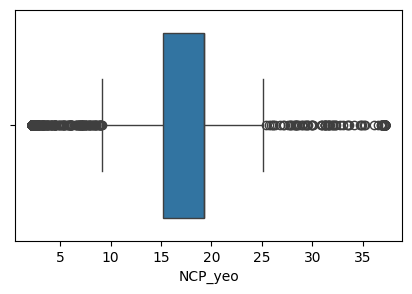

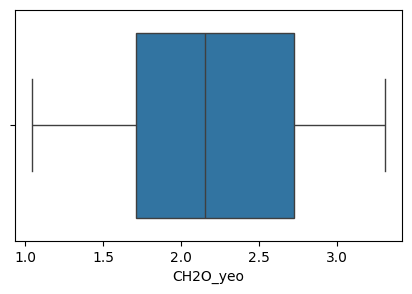

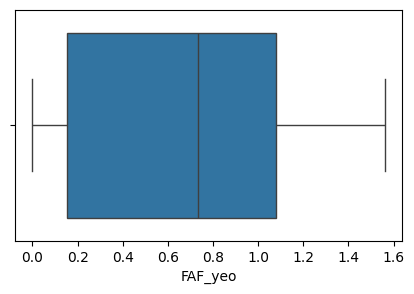

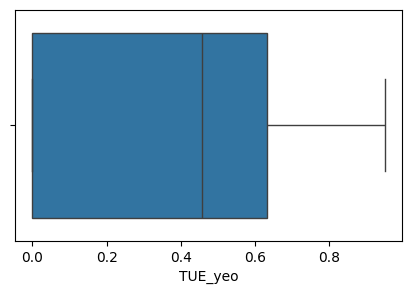

In [505]:
for i in X_train_num.columns:
  find_out(X_train_num,i)

In [506]:
# trimming on X_train_num

def trim(data,var):
  iqr = data[var].quantile(0.75)-data[var].quantile(0.25)
  upper = data[var].quantile(0.75)+(1.5 * iqr)
  lower = data[var].quantile(0.25)-(1.5 * iqr)
  return upper,lower


In [507]:
for i in X_train_num.columns:
  up,low=trim(X_train_num,i)
  X_train_num[i+'_trim']=np.where(X_train_num[i]>up,up,np.where(X_train_num[i]<low,low,X_train_num[i]))


In [508]:
for i in X_test_num.columns:
  up,low=trim(X_test_num,i)
  X_test_num[i+'_trim']=np.where(X_test_num[i]>up,up,np.where(X_test_num[i]<low,low,X_test_num[i]))


In [509]:
for i in X_train_num.columns:
  if '_trim' not in i:
    X_train_num=X_train_num.drop([i],axis=1)
X_train_num.columns

Index(['Age_yeo_trim', 'Height_yeo_trim', 'Weight_yeo_trim', 'FCVC_yeo_trim',
       'NCP_yeo_trim', 'CH2O_yeo_trim', 'FAF_yeo_trim', 'TUE_yeo_trim'],
      dtype='object')

In [510]:
for i in X_test_num.columns:
  if '_trim' not in i:
    X_test_num=X_test_num.drop([i],axis=1)
X_test_num.columns

Index(['Age_yeo_trim', 'Height_yeo_trim', 'Weight_yeo_trim', 'FCVC_yeo_trim',
       'NCP_yeo_trim', 'CH2O_yeo_trim', 'FAF_yeo_trim', 'TUE_yeo_trim'],
      dtype='object')

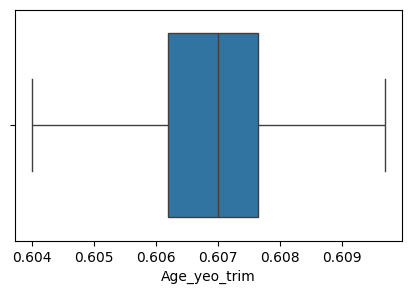

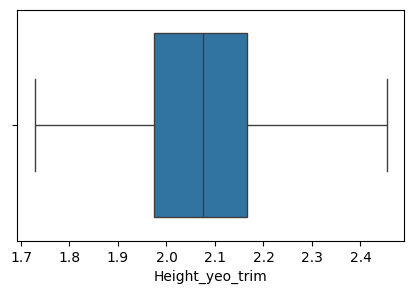

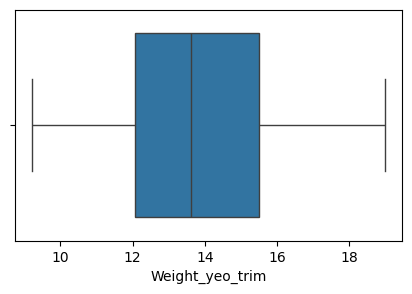

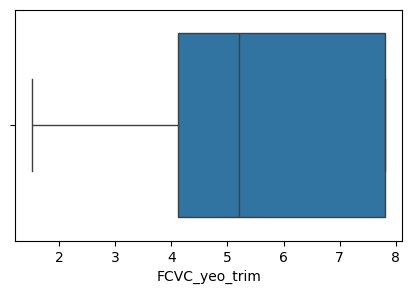

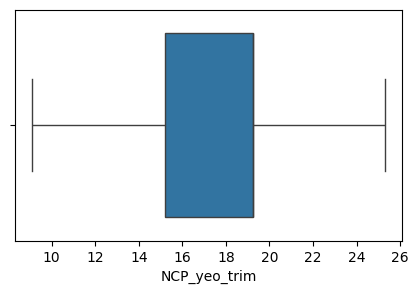

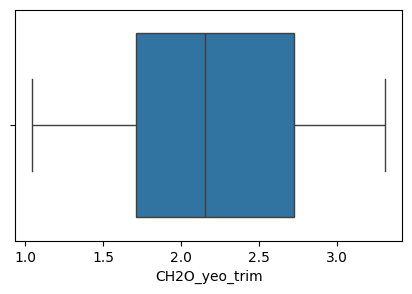

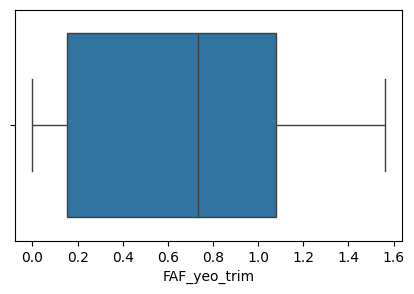

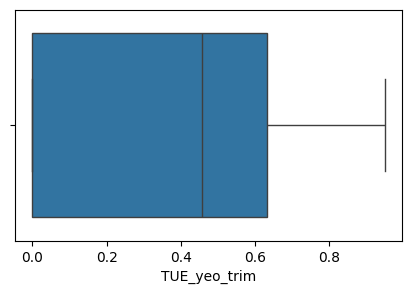

In [511]:
for i in X_train_num.columns:
  find_out(X_train_num,i)

Trimmming worked well.

In [512]:
X_train_num.sample(3)

,Age_yeo_trim,Height_yeo_trim,Weight_yeo_trim,FCVC_yeo_trim,NCP_yeo_trim,CH2O_yeo_trim,FAF_yeo_trim,TUE_yeo_trim
1743,0.607556,2.169117,16.026312,4.633066,19.229272,2.287872,0.909607,0.051231
1719,0.608243,2.152830,15.848762,2.104354,22.528270,2.134903,0.407120,0.000000
575,0.605396,2.132156,10.522743,2.298883,25.295255,1.045551,1.206414,0.632254


In [513]:
X_train_num.sample(3)

,Age_yeo_trim,Height_yeo_trim,Weight_yeo_trim,FCVC_yeo_trim,NCP_yeo_trim,CH2O_yeo_trim,FAF_yeo_trim,TUE_yeo_trim
1061,0.607142,2.106676,13.614826,6.632636,17.212692,1.623397,0.735073,0.156725
589,0.606221,1.837746,9.274407,2.745683,19.229272,2.134311,1.324475,0.504782
1440,0.608925,1.819164,13.392417,4.120620,19.229272,1.148831,0.000000,0.000000


In [514]:
X_train_cat.shape

(1688, 13)

In [515]:

X_train_num.reset_index(drop=True,inplace=True)

In [516]:
X_train_clean = pd.concat([X_train_num,X_train_cat],axis=1)
X_train_clean.sample(3)

,Age_yeo_trim,Height_yeo_trim,Weight_yeo_trim,FCVC_yeo_trim,NCP_yeo_trim,CH2O_yeo_trim,FAF_yeo_trim,TUE_yeo_trim,Gender_Female,Gender_Male,FAVC_no,FAVC_yes,SCC_no,SCC_yes,SMOKE_no,SMOKE_yes,family_history_with_overweight_no,family_history_with_overweight_yes,CALC,CAEC,MTRANS
567,0.608198,1.947408,10.469265,4.307963,25.295255,2.155559,0.631163,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,3.0
1317,0.608664,2.055832,10.522743,6.399881,25.295255,1.706752,0.163201,0.091418,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,3.0
759,0.606693,1.946670,12.339549,3.776086,25.295255,2.938696,0.802954,0.379617,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,3.0,3.0


In [517]:
X_train_clean.shape

(1688, 21)

In [518]:
X_test_num.reset_index(drop=True,inplace=True)

In [519]:
X_test_clean = pd.concat([X_test_num,X_test_cat],axis=1)
X_test_clean.sample(3)

,Age_yeo_trim,Height_yeo_trim,Weight_yeo_trim,FCVC_yeo_trim,NCP_yeo_trim,CH2O_yeo_trim,FAF_yeo_trim,TUE_yeo_trim,Gender_Female,Gender_Male,FAVC_no,FAVC_yes,SCC_no,SCC_yes,SMOKE_no,SMOKE_yes,family_history_with_overweight_no,family_history_with_overweight_yes,CALC,CAEC,MTRANS
172,0.597098,0.997845,22.697833,16.020434,14.643300,3.031227,0.907675,0.454567,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,3.0
78,0.596206,1.023333,12.519469,16.020434,17.676945,2.175277,1.168741,0.734809,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0
384,0.597924,0.998809,22.749382,16.020434,14.643300,2.918433,0.921119,0.554565,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,3.0


In [520]:
X_test_clean.shape

(423, 21)

In [521]:
#checking the order of columns whether column names are matching are not
c=[]
for i,j in enumerate(X_train_clean.columns):
  if X_test_clean.columns[i]==j:
    pass
  else:
    c.append(i)
print(c)

[]


4.Feature scaling

In [522]:
# 1.constant method : If the variance of any column is zero,then the column is removed
vt = VarianceThreshold(threshold=0.0)
vt.fit(X_train_clean)


VarianceThreshold()

In [523]:
sum(vt.get_support())
vt.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [524]:
~vt.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [525]:
X_train_clean.columns[vt.get_support()]

Index(['Age_yeo_trim', 'Height_yeo_trim', 'Weight_yeo_trim', 'FCVC_yeo_trim',
       'NCP_yeo_trim', 'CH2O_yeo_trim', 'FAF_yeo_trim', 'TUE_yeo_trim',
       'Gender_Female', 'Gender_Male', 'FAVC_no', 'FAVC_yes', 'SCC_no',
       'SCC_yes', 'SMOKE_no', 'SMOKE_yes', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'CALC', 'CAEC', 'MTRANS'],
      dtype='object')

In [526]:
X_train_clean.columns[~vt.get_support()]

Index([], dtype='object')

In [527]:
X_test_clean.columns[vt.get_support()]

Index(['Age_yeo_trim', 'Height_yeo_trim', 'Weight_yeo_trim', 'FCVC_yeo_trim',
       'NCP_yeo_trim', 'CH2O_yeo_trim', 'FAF_yeo_trim', 'TUE_yeo_trim',
       'Gender_Female', 'Gender_Male', 'FAVC_no', 'FAVC_yes', 'SCC_no',
       'SCC_yes', 'SMOKE_no', 'SMOKE_yes', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'CALC', 'CAEC', 'MTRANS'],
      dtype='object')

In [528]:
X_test_clean.columns[~vt.get_support()]

Index([], dtype='object')

Here,we have no columns to drop from the data


In [529]:
# 2.quasi constant method : if the variance must be 0.1
vt = VarianceThreshold(threshold = 0.1)
vt.fit(X_train_clean)


VarianceThreshold(threshold=0.1)

In [530]:
sum(vt.get_support())

15

In [531]:
sum(~vt.get_support())

6

In [532]:
X_train_clean.columns[vt.get_support()]

Index(['Weight_yeo_trim', 'FCVC_yeo_trim', 'NCP_yeo_trim', 'CH2O_yeo_trim',
       'FAF_yeo_trim', 'TUE_yeo_trim', 'Gender_Female', 'Gender_Male',
       'FAVC_no', 'FAVC_yes', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'CALC', 'CAEC', 'MTRANS'],
      dtype='object')

In [533]:
X_train_clean.columns[~vt.get_support()]

Index(['Age_yeo_trim', 'Height_yeo_trim', 'SCC_no', 'SCC_yes', 'SMOKE_no',
       'SMOKE_yes'],
      dtype='object')

In [534]:
X_test_clean.columns[vt.get_support()]

Index(['Weight_yeo_trim', 'FCVC_yeo_trim', 'NCP_yeo_trim', 'CH2O_yeo_trim',
       'FAF_yeo_trim', 'TUE_yeo_trim', 'Gender_Female', 'Gender_Male',
       'FAVC_no', 'FAVC_yes', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'CALC', 'CAEC', 'MTRANS'],
      dtype='object')

In [535]:
X_test_clean.columns[~vt.get_support()]

Index(['Age_yeo_trim', 'Height_yeo_trim', 'SCC_no', 'SCC_yes', 'SMOKE_no',
       'SMOKE_yes'],
      dtype='object')

In [536]:
X_train_clean = X_train_clean.drop(['Age_yeo_trim', 'Height_yeo_trim', 'SCC_no', 'SCC_yes', 'SMOKE_no',
       'SMOKE_yes'],axis=1)
X_test_clean = X_test_clean.drop(['Age_yeo_trim', 'Height_yeo_trim', 'SCC_no', 'SCC_yes', 'SMOKE_no',
       'SMOKE_yes'],axis=1)

In [537]:
X_train_clean.shape

(1688, 15)

we have 15 column.Now we are going to apply Hypothesis testing find the best columns for the model development

In [538]:
# Before that we have to work on target variable y_train
y_train.sample(5)


,obesity_level
632,Insufficient_Weight
1184,Overweight_Level_II
249,Overweight_Level_I
303,Normal_Weight
1879,Obesity_Type_III


In [539]:
# using the label encoding technique we are going to convert into numbers
lb_t = LabelEncoder()
lb_t.fit(y_train)
print(lb_t.classes_)
f = lb_t.transform(y_train)
y_train_n = pd.DataFrame(data = f,columns = ['obese_level'])
y_test_n = pd.DataFrame(data = lb_t.transform(y_test) , columns = ['obese_level'])

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [540]:
y_train_n

,obese_level
0,3
1,1
2,2
3,5
4,3
...,...
1683,6
1684,1
1685,0
1686,6


In [541]:
y_train_n['obese_level'].unique()

array([3, 1, 2, 5, 4, 0, 6])

In [542]:
# Hypothesis testing [pearson_correlation]
X_train_clean.columns

Index(['Weight_yeo_trim', 'FCVC_yeo_trim', 'NCP_yeo_trim', 'CH2O_yeo_trim',
       'FAF_yeo_trim', 'TUE_yeo_trim', 'Gender_Female', 'Gender_Male',
       'FAVC_no', 'FAVC_yes', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'CALC', 'CAEC', 'MTRANS'],
      dtype='object')

In [543]:
co = []
for i in X_train_clean.columns:
  s = pearsonr(X_train_clean[i] , y_train_n['obese_level'])
  co.append(s)


co = np.array(co)
co

array([[ 4.21474579e-01,  1.14650101e-73],
       [-6.74350892e-03,  7.81890032e-01],
       [-1.46395382e-01,  1.51441219e-09],
       [ 1.01119861e-01,  3.15289934e-05],
       [-1.35239327e-01,  2.43478298e-08],
       [-4.95161459e-02,  4.19389578e-02],
       [-2.80867392e-02,  2.48777354e-01],
       [ 2.80867392e-02,  2.48777354e-01],
       [-6.03118076e-02,  1.31992332e-02],
       [ 6.03118076e-02,  1.31992332e-02],
       [-3.11903439e-01,  2.09788509e-39],
       [ 3.11903439e-01,  2.09788509e-39],
       [-1.40412035e-01,  6.90101251e-09],
       [ 3.38346923e-01,  1.76160553e-46],
       [-3.62627981e-02,  1.36420692e-01]])

In [544]:
p_value = pd.Series(co[: , 1] , index = X_train_clean.columns)
p_value

,0
Weight_yeo_trim,1.146501e-73
FCVC_yeo_trim,7.818900e-01
NCP_yeo_trim,1.514412e-09
CH2O_yeo_trim,3.152899e-05
FAF_yeo_trim,2.434783e-08
TUE_yeo_trim,4.193896e-02
Gender_Female,2.487774e-01
Gender_Male,2.487774e-01
FAVC_no,1.319923e-02
FAVC_yes,1.319923e-02


In [575]:
k = []
n = list(p_value)
for i in p_value:
  if i > 0.05:
    k.append(n.index(i))
print(k)

[1, 6, 6, 14]


<Axes: >

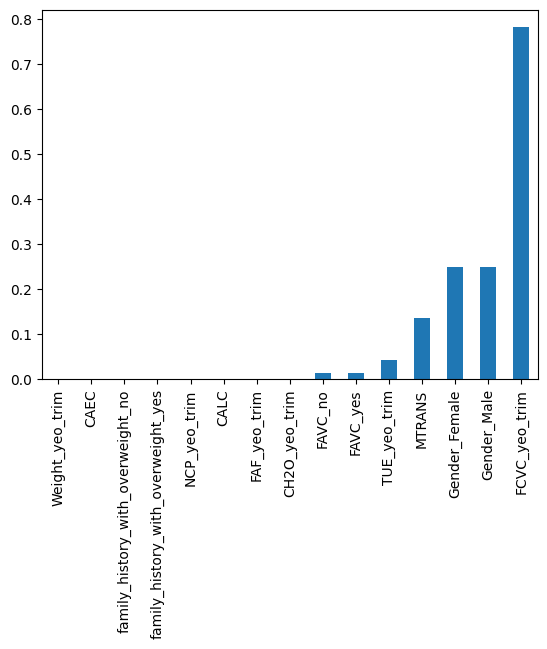

In [576]:
p_value.sort_values(ascending=True).plot.bar()

In [547]:
X_train_clean = X_train_clean.drop(['FAVC_no','FAVC_yes','TUE_yeo_trim','MTRANS','Gender_Female','Gender_Male','FCVC_yeo_trim'],axis=1)
X_test_clean = X_test_clean.drop(['FAVC_no','FAVC_yes','TUE_yeo_trim','MTRANS','Gender_Female','Gender_Male','FCVC_yeo_trim'],axis=1)

In [548]:
#after feature selection

X_train_clean.sample(5)

,Weight_yeo_trim,NCP_yeo_trim,CH2O_yeo_trim,FAF_yeo_trim,family_history_with_overweight_no,family_history_with_overweight_yes,CALC,CAEC
1564,11.150878,25.295255,2.323603,1.206414,0.0,1.0,2.0,2.0
517,13.405753,9.119299,2.076937,1.145587,0.0,1.0,2.0,2.0
265,11.800346,14.719452,2.224897,1.171106,1.0,0.0,2.0,2.0
1324,13.514227,9.119299,2.132694,0.022388,0.0,1.0,3.0,2.0
1253,16.425007,19.229272,3.070891,0.641745,0.0,1.0,2.0,2.0


In [549]:
X_train_clean.shape

(1688, 8)

In [550]:
X_test_clean.sample(5)

,Weight_yeo_trim,NCP_yeo_trim,CH2O_yeo_trim,FAF_yeo_trim,family_history_with_overweight_no,family_history_with_overweight_yes,CALC,CAEC
353,21.518706,14.643300,2.781287,1.041895,0.0,1.0,1.0,2.0
396,15.368280,22.706598,3.047309,1.296806,1.0,0.0,1.0,0.0
34,20.528148,14.643300,2.530751,0.000000,0.0,1.0,1.0,2.0
44,20.844177,14.643300,2.101090,0.896037,0.0,1.0,1.0,2.0
334,15.101546,14.643300,2.024036,0.000000,1.0,0.0,1.0,2.0


In [551]:
X_test_clean.shape

(423, 8)

In [552]:
y_train_n['obese_level'].value_counts()

,count
obese_level,
2,284
4,254
5,249
6,232
1,226
0,222
3,221


In [553]:
y_train_n['obese_level'].unique()

array([3, 1, 2, 5, 4, 0, 6])

In [554]:
y_train_n = np.array(y_train_n).ravel()
y_test_n = np.array(y_test_n).ravel()

**Now,Balancing the data using upsampling**

In [555]:
!pip install imblearn

In [556]:
print("Labels count for Insufficient_weight [0] = {}".format(sum(y_train_n == 0)))
print("Labels count for Normal_Weight  [1] = {} ".format(sum(y_train_n == 1)))
print("Labels count for Obesity_Type_I [2] = {}".format(sum(y_train_n == 2)))
print("Labels count for Obesity_Type_II [3]= {} ".format(sum(y_train_n == 3)))
print("Labels count for Obesity_Type_III [4]= {}".format(sum(y_train_n == 4)))
print("Labels count for Overweight_Level_I [5] = {} ".format(sum(y_train_n == 5)))
print("Labels count for Overweight_Level_II [6] = {} ".format(sum(y_train_n == 6)))
print()
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)

X_train_samp,y_train_samp = sm.fit_resample(X_train_clean,y_train_n)
print("Labels count for Insufficient_weight [0] = {}".format(sum(y_train_samp == 0)))
print("Labels count for Normal_Weight  [1] = {} ".format(sum(y_train_samp == 1)))
print("Labels count for Obesity_Type_I [2] = {}".format(sum(y_train_samp == 2)))
print("Labels count for Obesity_Type_II [3]= {} ".format(sum(y_train_samp == 3)))
print("Labels count for Obesity_Type_III [4]= {}".format(sum(y_train_samp == 4)))
print("Labels count for Overweight_Level_I [5] = {} ".format(sum(y_train_samp == 5)))
print("Labels count for Overweight_Level_II [6] = {} ".format(sum(y_train_samp == 6)))


Labels count for Insufficient_weight [0] = 222
Labels count for Normal_Weight  [1] = 226 
Labels count for Obesity_Type_I [2] = 284
Labels count for Obesity_Type_II [3]= 221 
Labels count for Obesity_Type_III [4]= 254
Labels count for Overweight_Level_I [5] = 249 
Labels count for Overweight_Level_II [6] = 232 

Labels count for Insufficient_weight [0] = 284
Labels count for Normal_Weight  [1] = 284 
Labels count for Obesity_Type_I [2] = 284
Labels count for Obesity_Type_II [3]= 284 
Labels count for Obesity_Type_III [4]= 284
Labels count for Overweight_Level_I [5] = 284 
Labels count for Overweight_Level_II [6] = 284 


**Now,the data has been balanced and ready to get trained**

In [557]:
X_train_samp.sample(2)

,Weight_yeo_trim,NCP_yeo_trim,CH2O_yeo_trim,FAF_yeo_trim,family_history_with_overweight_no,family_history_with_overweight_yes,CALC,CAEC
1609,13.545300,9.119299,1.737855,0.666270,0.0,1.0,2.0,2.0
668,14.512922,18.469140,1.381364,0.963407,0.0,1.0,2.0,2.0


In [558]:
y_train_samp.shape

(1988,)

**RandomForestClassifier**

In [577]:
ran_c = RandomForestClassifier(criterion = 'entropy',n_estimators=11)
ran_c.fit(X_train_samp,y_train_samp)

RandomForestClassifier(criterion='entropy', n_estimators=11)

In [578]:
#prediction
y_train_pred = ran_c.predict(X_train_samp)
y_ran_pred = ran_c.predict(X_test_clean)

In [579]:
# Train_performance
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('performance of the model with Trained data :')
print()
print(f'1.Accuracy_score : {accuracy_score(y_train_samp,y_train_pred)}')
print()
print(f'2.confusion_matrix : {confusion_matrix(y_train_samp,y_train_pred)}')
print()
print(f'3.classification_report:')
print(f'{classification_report(y_train_samp,y_train_pred)}')

performance of the model with Trained data :

1.Accuracy_score : 0.9969818913480886

2.confusion_matrix : [[284   0   0   0   0   0   0]
 [  1 281   0   0   0   1   1]
 [  0   0 283   0   0   0   1]
 [  0   0   0 284   0   0   0]
 [  0   0   0   0 284   0   0]
 [  0   2   0   0   0 282   0]
 [  0   0   0   0   0   0 284]]

3.classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       0.99      0.99      0.99       284
           2       1.00      1.00      1.00       284
           3       1.00      1.00      1.00       284
           4       1.00      1.00      1.00       284
           5       1.00      0.99      0.99       284
           6       0.99      1.00      1.00       284

    accuracy                           1.00      1988
   macro avg       1.00      1.00      1.00      1988
weighted avg       1.00      1.00      1.00      1988



In [563]:
# Test_performance
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('performance of the model with Test data :')
print()
print(f'1.Accuracy_score : {accuracy_score(y_test_n,y_ran_pred)}')
print()
print(f'2.confusion_matrix : {confusion_matrix(y_test_n,y_ran_pred)}')
print()
print(f'3.classification_report:')
print(f'{classification_report(y_test_n,y_ran_pred)}')

performance of the model with Test data :

1.Accuracy_score : 0.25295508274231676

2.confusion_matrix : [[ 0 26  0  0  0 20  4]
 [ 0 23  7  7  0 17  7]
 [ 0  1  2 64  0  0  0]
 [ 0  0  0 73  3  0  0]
 [ 0  0  0 69  0  0  1]
 [ 0  2 10 15  5  6  3]
 [ 0  4  1 50  0  0  3]]

3.classification_report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.41      0.38      0.39        61
           2       0.10      0.03      0.05        67
           3       0.26      0.96      0.41        76
           4       0.00      0.00      0.00        70
           5       0.14      0.15      0.14        41
           6       0.17      0.05      0.08        58

    accuracy                           0.25       423
   macro avg       0.15      0.22      0.15       423
weighted avg       0.16      0.25      0.16       423



**XGBoost**

In [581]:
x_c = XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.1)
x_c.fit(X_train_samp,y_train_samp)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [582]:
y_train_predx = [round(value) for value in x_c.predict(X_train_samp)]
y_train_predx

[3,
 1,
 2,
 5,
 3,
 5,
 5,
 2,
 4,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 1,
 2,
 0,
 5,
 4,
 0,
 3,
 5,
 0,
 0,
 6,
 3,
 0,
 2,
 1,
 1,
 6,
 6,
 0,
 2,
 3,
 0,
 2,
 3,
 1,
 3,
 2,
 1,
 1,
 1,
 0,
 4,
 1,
 4,
 4,
 4,
 2,
 4,
 1,
 5,
 4,
 5,
 4,
 2,
 3,
 0,
 0,
 1,
 4,
 0,
 2,
 6,
 0,
 6,
 1,
 6,
 4,
 6,
 2,
 0,
 3,
 3,
 3,
 0,
 5,
 3,
 0,
 5,
 2,
 6,
 1,
 5,
 5,
 6,
 2,
 4,
 2,
 3,
 4,
 3,
 4,
 1,
 5,
 1,
 4,
 2,
 3,
 5,
 1,
 5,
 3,
 1,
 6,
 3,
 4,
 4,
 1,
 1,
 2,
 1,
 4,
 3,
 6,
 5,
 4,
 1,
 5,
 6,
 0,
 6,
 6,
 4,
 3,
 3,
 5,
 2,
 1,
 5,
 3,
 6,
 3,
 6,
 2,
 2,
 2,
 1,
 6,
 1,
 4,
 6,
 5,
 1,
 0,
 5,
 6,
 5,
 5,
 1,
 0,
 0,
 6,
 1,
 1,
 6,
 2,
 3,
 5,
 6,
 6,
 2,
 0,
 5,
 3,
 4,
 2,
 5,
 2,
 4,
 4,
 0,
 5,
 6,
 3,
 5,
 2,
 3,
 2,
 5,
 4,
 3,
 0,
 1,
 0,
 2,
 2,
 4,
 1,
 0,
 6,
 5,
 1,
 1,
 6,
 1,
 6,
 4,
 2,
 2,
 3,
 4,
 2,
 6,
 1,
 4,
 3,
 1,
 0,
 1,
 4,
 0,
 4,
 4,
 0,
 0,
 4,
 1,
 5,
 1,
 0,
 6,
 4,
 5,
 2,
 6,
 6,
 6,
 2,
 2,
 2,
 4,
 1,
 2,
 0,
 6,
 2,
 0,
 6,
 6,
 5,
 6,
 5,
 5,
 0,
 0,


In [583]:
y_xg_pred = [round(value) for value in x_c.predict(X_test_clean)]
y_xg_pred

[4,
 4,
 1,
 3,
 2,
 2,
 1,
 4,
 3,
 5,
 5,
 1,
 4,
 2,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 2,
 3,
 4,
 2,
 2,
 4,
 2,
 6,
 2,
 4,
 5,
 1,
 4,
 3,
 6,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 1,
 4,
 2,
 4,
 4,
 1,
 5,
 3,
 3,
 2,
 2,
 6,
 1,
 4,
 2,
 4,
 6,
 4,
 5,
 5,
 2,
 4,
 4,
 1,
 2,
 4,
 2,
 3,
 6,
 6,
 2,
 2,
 5,
 3,
 3,
 3,
 5,
 4,
 3,
 3,
 5,
 3,
 2,
 3,
 2,
 4,
 2,
 6,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 5,
 3,
 4,
 3,
 2,
 5,
 4,
 4,
 6,
 6,
 4,
 3,
 2,
 2,
 4,
 6,
 4,
 2,
 4,
 3,
 4,
 1,
 4,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 5,
 4,
 5,
 3,
 4,
 5,
 6,
 3,
 5,
 3,
 3,
 4,
 4,
 2,
 4,
 2,
 3,
 4,
 6,
 3,
 4,
 6,
 3,
 3,
 4,
 2,
 2,
 3,
 2,
 3,
 4,
 4,
 3,
 3,
 4,
 4,
 4,
 1,
 4,
 6,
 5,
 4,
 6,
 3,
 4,
 3,
 2,
 3,
 4,
 2,
 3,
 6,
 4,
 5,
 6,
 1,
 1,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 6,
 3,
 3,
 3,
 1,
 5,
 3,
 2,
 4,
 3,
 1,
 2,
 4,
 4,
 3,
 3,
 4,
 2,
 4,
 4,
 4,
 4,
 2,
 6,
 6,
 5,
 2,
 3,
 3,
 4,
 3,
 2,
 4,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 1,
 3,
 3,
 4,
 4,
 2,
 2,
 3,
 4,
 2,
 2,
 2,
 6,
 3,


In [584]:
# Train_performance
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('performance of the model with Trained data :')
print()
print(f'1.Accuracy_score : {accuracy_score(y_train_samp,y_train_predx)}')
print()
print(f'2.confusion_matrix : {confusion_matrix(y_train_samp,y_train_predx)}')
print()
print(f'3.classification_report:')
print(f'{classification_report(y_train_samp,y_train_predx)}')

performance of the model with Trained data :

1.Accuracy_score : 0.9607645875251509

2.confusion_matrix : [[279   5   0   0   0   0   0]
 [  2 274   1   0   0   5   2]
 [  0   0 267   0   2   2  13]
 [  0   0   0 284   0   0   0]
 [  0   0   0   1 283   0   0]
 [  0  14   1   0   0 257  12]
 [  0   6   7   0   0   5 266]]

3.classification_report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       284
           1       0.92      0.96      0.94       284
           2       0.97      0.94      0.95       284
           3       1.00      1.00      1.00       284
           4       0.99      1.00      0.99       284
           5       0.96      0.90      0.93       284
           6       0.91      0.94      0.92       284

    accuracy                           0.96      1988
   macro avg       0.96      0.96      0.96      1988
weighted avg       0.96      0.96      0.96      1988



In [585]:
# Test_performance
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print('performance of the model with Test data :')
print()
print(f'1.Accuracy_score : {accuracy_score(y_test_n,y_xg_pred)}')
print()
print(f'2.confusion_matrix : {confusion_matrix(y_test_n,y_xg_pred)}')
print()
print(f'3.classification_report:')
print(f'{classification_report(y_test_n,y_xg_pred)}')

performance of the model with Test data :

1.Accuracy_score : 0.2789598108747045

2.confusion_matrix : [[ 0 16  1  0  0 20 13]
 [ 0  8 15  8  1 11 18]
 [ 0  0 19 33 15  0  0]
 [ 0  0  3 36 37  0  0]
 [ 0  0  0 19 51  0  0]
 [ 0  0 14 11 10  1  5]
 [ 0  0 18 33  4  0  3]]

3.classification_report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.33      0.13      0.19        61
           2       0.27      0.28      0.28        67
           3       0.26      0.47      0.33        76
           4       0.43      0.73      0.54        70
           5       0.03      0.02      0.03        41
           6       0.08      0.05      0.06        58

    accuracy                           0.28       423
   macro avg       0.20      0.24      0.20       423
weighted avg       0.22      0.28      0.23       423



**finalising the best model**

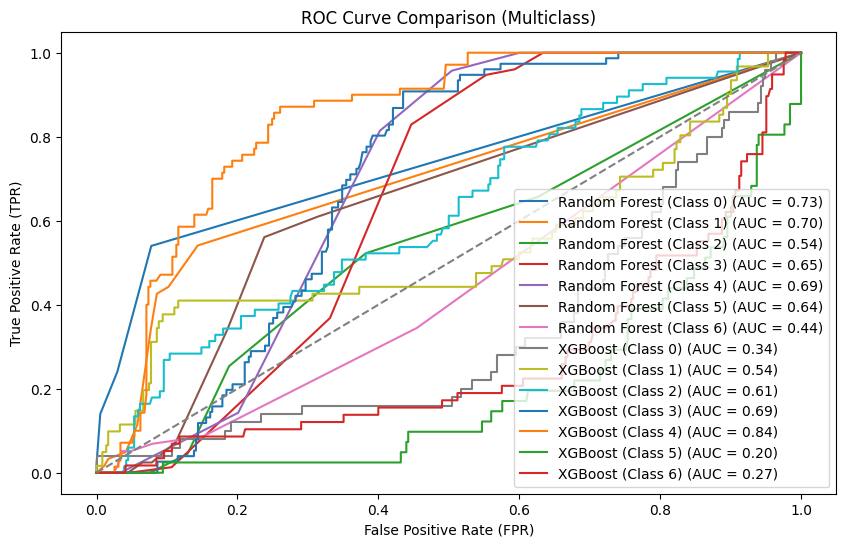

AUC for Random Forest (Class 0): 0.73
AUC for XGBoost (Class 0): 0.34
AUC for Random Forest (Class 1): 0.70
AUC for XGBoost (Class 1): 0.54
AUC for Random Forest (Class 2): 0.54
AUC for XGBoost (Class 2): 0.61
AUC for Random Forest (Class 3): 0.65
AUC for XGBoost (Class 3): 0.69
AUC for Random Forest (Class 4): 0.69
AUC for XGBoost (Class 4): 0.84
AUC for Random Forest (Class 5): 0.64
AUC for XGBoost (Class 5): 0.20
AUC for Random Forest (Class 6): 0.44
AUC for XGBoost (Class 6): 0.27


In [587]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming you have your test data and trained models
# X_test: Features for the test set
# y_test: True labels for the test set
# y_ran_pred: Predictions from RandomForest model (probabilities for all classes)
# y_xg_pred: Predictions from XGBoost model (probabilities for all classes)

# 1. Binarize the true labels for multiclass
n_classes = len(np.unique(y_test))  # Number of classes
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # One-hot encoding for multiclass

# 2. Get predicted probabilities for all classes
y_ran_pred = ran_c.predict_proba(X_test_clean)  # Probabilities for all classes
y_xg_pred = x_c.predict_proba(X_test_clean)  # Probabilities for all classes

# 3. Initialize plot
plt.figure(figsize=(10, 6))

# 4. Compute ROC curve and AUC for each class for Random Forest
for i in range(n_classes):
    fpr_random, tpr_random, _ = roc_curve(y_test_bin[:, i], y_ran_pred[:, i])
    auc_random = auc(fpr_random, tpr_random)
    plt.plot(fpr_random, tpr_random, label=f'Random Forest (Class {i}) (AUC = {auc_random:.2f})')

# 5. Compute ROC curve and AUC for each class for XGBoost
for i in range(n_classes):
    fpr_xg, tpr_xg, _ = roc_curve(y_test_bin[:, i], y_xg_pred[:, i])
    auc_xg = auc(fpr_xg, tpr_xg)
    plt.plot(fpr_xg, tpr_xg, label=f'XGBoost (Class {i}) (AUC = {auc_xg:.2f})')

# 6. Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Labels and title
plt.title('ROC Curve Comparison (Multiclass)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')

# Show plot
plt.show()

# 7. Print AUC for each class for Random Forest and XGBoost
for i in range(n_classes):
    fpr_random, tpr_random, _ = roc_curve(y_test_bin[:, i], y_ran_pred[:, i])
    auc_random = auc(fpr_random, tpr_random)
    print(f'AUC for Random Forest (Class {i}): {auc_random:.2f}')

    fpr_xg, tpr_xg, _ = roc_curve(y_test_bin[:, i], y_xg_pred[:, i])
    auc_xg = auc(fpr_xg, tpr_xg)
    print(f'AUC for XGBoost (Class {i}): {auc_xg:.2f}')


**On comparing both models , RandomForestClassifier is the best model**

In [571]:
X_train_samp.columns

Index(['Weight_yeo_trim', 'NCP_yeo_trim', 'CH2O_yeo_trim', 'FAF_yeo_trim',
       'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'CALC', 'CAEC'],
      dtype='object')

In [572]:
p=ran_c.predict([[20.393129,	14.6433,	2.727712,	0.000000,	0.0,	1.0,	1.0,	2.0]])
if  p== 0:
  print('Insufficient_Weight')
elif p==1:
  print('Normal_Weight')
elif p==2:
  print('Overweight_Level_I')
elif p==3:
  print('Overweight_Level_II')
elif p==4:
  print('Obesity_Type_I')
elif p==5:
  print('Obesity_Type_II')
else:
  print('Obesity_Type_III')

Overweight_Level_II


**saving the model**

In [573]:
import pickle

In [574]:
with open('obesity_level.pkl','wb') as f:
  pickle.dump(ran_c,f)